In [113]:
import pandahouse
import seaborn as sns
import scipy.stats as stats
import numpy as np

In [114]:
# Подключаемся и извлекаем данные
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT
    exp_group,
    user_id,
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views,
    likes / NULLIF(views, 0) AS ctr
FROM simulator_20250520.feed_actions
WHERE
    toDate(time) BETWEEN '2025-05-02' AND '2025-05-08'
  AND exp_group IN (1, 2)
GROUP BY
    exp_group,
    user_id
HAVING
    views > 0
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [115]:
#T-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

p-value примерно 0.685, что > 0.05. Следовательно, на основании T-теста мы не отвергаем нулевую гипотезу (нет статистически значимого различия в средних CTR между группой 1 и группой 2)

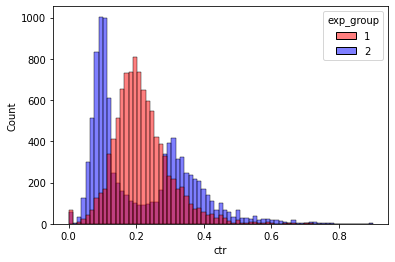

In [117]:
# Смотрим гистограмму
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Из гистограммы видно, что: участники контрольной группы (группа 1) в среднем имеют более высокий CTR, чем участники экспериментальной (группа 2). Но сильное перекрытие распределений говорит о том, что отличия не являются радикальными: многие пользователи из группы 2 показывают такие же или даже лучшие CTR, чем часть пользователей из группы 1. Распределения асимметричны, и есть смещение "длинного правого хвоста".

In [119]:
# тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Если бы распределения CTR в двух группах на самом деле были одинаковы, то шанс получить такое различие в рангах (U-статистика) около 4·10^(-45), то есть практически равен нулю. Следовательно, мы отвергаем нулевую гипотезу H0 о равенстве распределений. То есть распределения CTR в группах 1 и 2 статистически различаются. Учитывая, что на гистограмме выше мы увидели, что у группы 1 пик около 0.20–0.30, а у группы 2 — около 0.10–0.20, Манн-Уитни подтверждает, что в большинстве случаев значение CTR в группе 1 действительно больше, чем значение CTR в группе 2.

In [121]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 55.01 % случаев A > B. Должно получиться около 50%


То есть контрольная группа (1) "выигрывает" по CTR чаще, чем экспериментальная (2).

In [123]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha=5):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

<Axes: xlabel='ctr', ylabel='Count'>

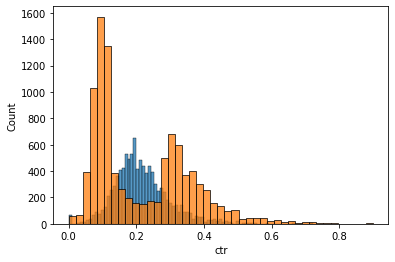

In [124]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr, 
             kde = False)

group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr, 
             kde = False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

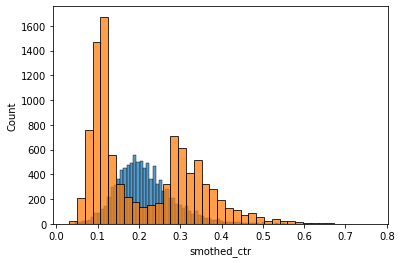

In [125]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group1.smothed_ctr, 
             kde = False)
sns.histplot(group2.smothed_ctr, 
             kde = False)

После "сглаженного" CTR контрольная группа уверенно показывает более высокие значения, а экспериментальная - более низкие. Сглаживание лишь подтверждает, что это не артефакт "мелких" пользователей с 1–2 просмотрами, а действительно устойчивая закономерность.

In [127]:
# t-тест на сглаженном ctr
stats.ttest_ind(group1.ctr,
                group2.ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Параметрический t-тест по сглаженным данным по-прежнему не находит статистически значимого различия между средними сглаженными CTR.

In [129]:
# Пуассоновский бутстреп
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [130]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

<Axes: ylabel='Count'>

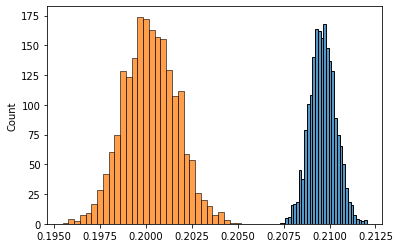

In [131]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

В бутстреп-попытках глобальный CTR для A (контроль) оказывается выше, чем для B (эксперимент).

<Axes: ylabel='Count'>

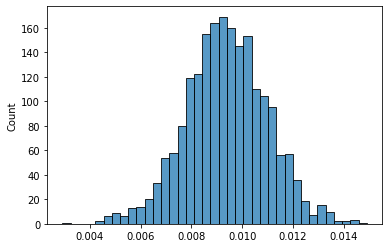

In [133]:
#Разница между глобальными CTR
sns.histplot(ctr1 - ctr2)

С вероятностью близкой к 100% глобальный CTR группы A выше глобального CTR группы B.

In [135]:
qBucket = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20250520.feed_actions
    WHERE toDate(time) between '2025-05-02' and '2025-05-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

dfBucket = pandahouse.read_clickhouse(qBucket, connection=connection)

In [136]:
# тест Манна-Уитни поверх бакетного преобразования
stats.mannwhitneyu(dfBucket[dfBucket.exp_group == 1].bucket_ctr, 
                   dfBucket[dfBucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

Сигнал о том, что распределения bucket_ctr в группах 1 и 2 сильно отличаются. Контрольная группа (exp_group = 1) выигрывает по бакетному CTR - её корзины чаще имеют вышее значение CTR, чем корзины из экспериментальной группы.

In [138]:
# t-тест поверх бакетного преобразования
stats.ttest_ind(dfBucket[dfBucket.exp_group == 1].bucket_ctr, 
                   dfBucket[dfBucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

Параметрический t-тест на бакетах показывает, что средние агрегированные CTR (bucket_ctr) контрольной и экспериментальной групп статистически значимо отличаются. И поскольку t-статистика положительна (примерно 5.6), это говорит в пользу того, что средний bucket_ctr из контрольных корзин выше, чем средний bucket_ctr из экспериментальных корзин.

<Axes: xlabel='bucket_ctr', ylabel='Count'>

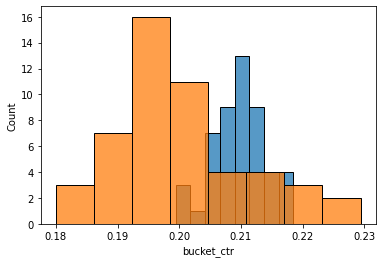

In [140]:
sns.histplot(dfBucket[dfBucket.exp_group == 1].bucket_ctr)
sns.histplot(dfBucket[dfBucket.exp_group == 2].bucket_ctr)

В большинстве бакетов контрольная группа устойчиво показывает чуть более высокий средний CTR (примерно 0.21)

<Axes: xlabel='ctr9', ylabel='Count'>

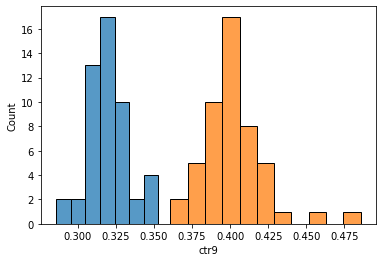

In [142]:
sns.histplot(dfBucket[dfBucket.exp_group == 1].ctr9)
sns.histplot(dfBucket[dfBucket.exp_group == 2].ctr9)

В контрольных корзинах даже самые активные 10% показывают максимальную глубокую эффективность не выше примерно 0.33. В экспериментальных корзинах самые активные 10% пользователей гораздо более лайкоориентированы и достигают CTR практически 0.40–0.42. Хотя в среднем эксперимент отстаёт, в топ-10% своего бакета (то есть среди наиболее затейливых читателей) экспериментальный алгоритм выдаёт куда более высокие CTR, чем контрольный.

Следовательно в "середине" пользовательской базы контрольная группа выигрывает по среднему CTR, а в топе самых активных 10% экспериментальная группа даёт существенно более высокий CTR.

В среднем по всем пользователям эксперимент снижает CTR, но для самой активной десятки (топ 10%) новый алгоритм даёт куда более высокие значения CTR, чем контроль.

Ответы на последние 2 вопроса и итог: запускать новый алгоритм на всех не стоит, поскольку средний CTR упадёт. Но экспериментальный алгоритм имеет потенциал для "выжимания" высокоактивных пользователей, поэтому есть смысл тестировать/внедрить его селективно (либо доработать так, чтобы он давал хоть такой же средний CTR, как контроль, одновременно удерживая и топ). Таким образом, проделанный анализ оказался комплексным, многослойным и позволил не только увидеть статистически значимую разницу CTR, но и понять, как именно новый алгоритм работает на разные подгруппы пользователей. Это позволяет сформулировать адекватную стратегию по дальнейшему внедрению (сегментированное или дополнительное дообучение), а не слепо переключать всю базу под новую логику рекомендаций.